In [70]:
# Basic imports
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from math import sqrt

# Validation
from sklearn.model_selection import TimeSeriesSplit

# Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# Neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping

# Neural networks optimization
from keras.models import clone_model
from tensorflow.keras.optimizers import SGD # SGD (Stochastic Gradient Descent)
from tensorflow.keras.optimizers import RMSprop # RMSprop (Root Mean Square Propagation)
from tensorflow.keras.optimizers import Adam # Adam (Adaptive Moment Estimation)
from tensorflow.keras.optimizers import Adadelta # Adadelta stands for "Adaptive Delta" 
from tensorflow.keras.optimizers import Adagrad # Adagrad stands for "Adaptive Gradient"
from tensorflow.keras.optimizers import Adamax # Adamax is a variant of the Adam optimizer
# that uses the infinity norm (max norm) instead of the L2 norm for weight updates.
from tensorflow.keras.optimizers import Nadam # Nadam (Nesterov-accelerated Adaptive Moment Estimation)
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm


In [7]:
def wmape(y_true, y_pred):
    # Prevent from dividing by 0 like in MAPE
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [66]:
class DeepTimeSeriesForecaster:
    def __init__(self, model=None):
        self.model = model
    
    def prepare_data(self, data, categorical_col_name, targets, steps_ahead):
        self.categorical_col_name = categorical_col_name
        self.targets = []
        # Need to copy, otherwise weirdly is working on the parameters passed directly
        data = data.copy()
        data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in data.iterrows()]
        data["Date"] = pd.to_datetime(data["Date"])
        data.index = data["Date"]
        data[categorical_col_name] = data[categorical_col_name].astype("category")

        day = 60*60*24
        year = 365.2425*day

        data["Seconds"] = data["Date"].map(pd.Timestamp.timestamp)

        # Creating date related fields standardized for the purpose of learning
        data['Year sin'] = np.sin(data['Seconds'] * (2 * np.pi / year))
        data['Year cos'] = np.cos(data['Seconds'] * (2 * np.pi / year))

        data.drop(columns=["Seconds", "Date"], inplace=True)

        # Data standarization - saving the mean and std for each column for further reversal processing
        columns_to_scale = data.drop(columns=[self.categorical_col_name, "year", "month", "Year sin", "Year cos"]).columns.values
        self.data_mean = data[columns_to_scale].mean()
        self.data_std = data[columns_to_scale].std()

        data[columns_to_scale] = (data[columns_to_scale] - self.data_mean)/self.data_std

        for target in targets:
            for i in range(1, steps_ahead+1):
                data[f"{target}_+{i}"] = data.groupby(categorical_col_name)[target].shift(-i)
                self.targets.append(f"{target}_+{i}")
        
        data = data.dropna()

        self.data = data

        return self
    
    def get_data(self):
        return self.data

    def split_category_data(self, n_splits):
        data_dict = {f"iter_{i}": {"train": pd.DataFrame(), "valid": pd.DataFrame(), "test": pd.DataFrame()} for i in range(1, n_splits+1)}

        # Tworzenie TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for category in data[self.categorical_col_name].unique():
            for i, (train_index, test_index) in enumerate(tscv.split(self.data[self.data[self.categorical_col_name] == category].index.values)):
                train_data = self.data[self.data[self.categorical_col_name] == category].iloc[train_index]
                valid_data = self.data[self.data[self.categorical_col_name] == category].iloc[test_index]
                test_data = pd.DataFrame(valid_data.tail(6))
                valid_data = valid_data.iloc[:-6, :]

                data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
                data_dict[f"iter_{i+1}"]["valid"] = data_dict[f"iter_{i+1}"]["valid"].append(valid_data, ignore_index=True)
                data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)
        
        return data_dict

    def df_to_X_y_lags(self, df, window_size=12):
        # Get the indexes of the specific target columns
        column_indexes = [df.columns.get_loc(col) for col in self.targets]
        df_as_np = df.to_numpy()
        exploatory_variables = np.delete(df_as_np, column_indexes, axis=1)
        X = []
        y = []
        for i in range(len(df_as_np) - window_size):
            row = [r for r in exploatory_variables[i:i+window_size]]
            X.append(row)
            label = df_as_np[i + window_size][column_indexes]
            y.append(label)
        return np.array(X), np.array(y)

    def df_to_X_y(self, df):
        # Get the indexes of the specific target columns
        column_indexes = [df.columns.get_loc(col) for col in self.targets]
        # date_index = df.columns.get_loc("Date")
        # dates = df.to_numpy()[:, date_index]

        df_as_np = df.to_numpy()
        exploatory_variables = np.delete(df_as_np, column_indexes, axis=1)
        X = exploatory_variables.reshape((len(exploatory_variables), 1, exploatory_variables.shape[1]))
        y = df_as_np[:, column_indexes]
        return X.astype(np.float32), y.astype(np.float32)

    def train_model(self, train, valid, test, lag=0, local=False):
        if local == False:
            # One-hot encoding  
            train_dummies = pd.get_dummies(train, columns=[self.categorical_col_name])
            valid_dummies = pd.get_dummies(valid, columns=[self.categorical_col_name])
            test_dummies = pd.get_dummies(test, columns=[self.categorical_col_name])

            if lag > 0:
                X_train, y_train = self.df_to_X_y_lags(train_dummies.drop(columns = ["year", "month"]), window_size=lag)
                X_valid, y_valid = self.df_to_X_y_lags(valid_dummies.drop(columns = ["year", "month"]), window_size=lag)
                X_test, y_test = self.df_to_X_y_lags(test_dummies.drop(columns = ["year", "month"]), window_size=lag)
            else:
                X_train, y_train = self.df_to_X_y(train_dummies.drop(columns = ["year", "month"]))
                X_valid, y_valid = self.df_to_X_y(valid_dummies.drop(columns = ["year", "month"]))
                X_test, y_test = self.df_to_X_y(test_dummies.drop(columns = ["year", "month"]))
        else:
            if lag > 0:
                X_train, y_train = self.df_to_X_y_lags(train_dummies.drop(columns = ["year", "month"]), window_size=lag)
                X_valid, y_valid = self.df_to_X_y_lags(valid_dummies.drop(columns = ["year", "month"]), window_size=lag)
                X_test, y_test = self.df_to_X_y_lags(test_dummies.drop(columns = ["year", "month"]), window_size=lag)
            else:
                X_train, y_train = self.df_to_X_y(train_dummies.drop(columns = ["year", "month"]))
                X_valid, y_valid = self.df_to_X_y(valid_dummies.drop(columns = ["year", "month"]))
                X_test, y_test = self.df_to_X_y(test_dummies.drop(columns = ["year", "month"]))

        print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

        callback = EarlyStopping(monitor='loss', patience=5)
        history = self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, callbacks=[callback], verbose=0)

        preds = self.model.predict(X_test)

        preds = pd.DataFrame(preds)
        y_test = pd.DataFrame(y_test)

        preds.rename(columns={i: f"{t}_pred" for i, t in enumerate(self.targets)}, inplace=True)
        y_test.rename(columns={i: t for i, t in enumerate(self.targets)}, inplace=True)

        for target in self.targets:
            preds[f"{target}_pred"] = preds[f"{target}_pred"] * self.data_std[target.split("_")[0]] + self.data_mean[target.split("_")[0]]
            y_test[target] = y_test[target] * self.data_std[target.split("_")[0]] + self.data_mean[target.split("_")[0]]
        
        preds[["FarmID", "year", "month"]] = test[["FarmID", "year", "month"]].iloc[lag:, :].values
        y_test[["FarmID", "year", "month"]] = test[["FarmID", "year", "month"]].iloc[lag:, :].values
        
        return preds, y_test, history

    def random_search(self, param_grid, num_samples):
        random_combinations = []

        while len(random_combinations) < num_samples:
            random_combination = {}
            for param, values in param_grid.items():
                random_value = random.choice(values)
                random_combination[param] = random_value

            if random_combination not in random_combinations:
                random_combinations.append(random_combination)

        return random_combinations

    def grid_search(self, param_grid):
        # Generate all combinations of parameters
        grid_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        return grid_combinations

    def optimize_model(self, build_model, param_grid, input_dim = (1, 91), output_num = 12, cv_splits = 5, search_method = "random", num_samples = 60, lag=0):
        list_rmse = []
        if search_method == "random":
            all_params = self.random_search(param_grid, num_samples)
            # Use cross validation to evaluate all parameters
            self.data_dict = self.split_category_data(cv_splits)
            for i, params in enumerate(all_params):
                optimizer = {"SGD": SGD(learning_rate=params["learning_rate"]), "RMSprop": RMSprop(learning_rate=params["learning_rate"]), 
                            "Adam": Adam(learning_rate=params["learning_rate"]), "Adadelta": Adadelta(learning_rate=params["learning_rate"]), 
                            "Adagrad": Adagrad(learning_rate=params["learning_rate"]), "Adamax": Adamax(learning_rate=params["learning_rate"]), 
                            "Nadam": Nadam(learning_rate=params["learning_rate"])}
                params["optimizer"] = optimizer[params["optimizer"]]
                model = build_model(input_dim, output_num, params)
                self.model = model
                print(f"Searching: {i+1}/{len(all_params)}")
                print(params)
                temp_rmse = []
                for i in range(1, cv_splits+1):
                    train, valid, test = self.data_dict[f"iter_{i}"]["train"], self.data_dict[f"iter_{i}"]["valid"], self.data_dict[f"iter_{i}"]["test"]

                    preds, real, history = self.train_model(train, valid, test, lag)

                    # Here collect preds and reals into one nice table
                    temp_outcome = pd.concat([preds, real.drop(columns=["FarmID", "year", "month"])], axis=1)
                    temp_outcome["Iter_n"] = i
                    
                    # Get scores for the provided preds and reals (can be seperated function)
                    tbl_scores = self.get_scores(temp_outcome)
                    temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])
                list_rmse.append(temp_rmse)
        # Tuning results
        tuning_results = pd.DataFrame(all_params)
        tuning_results['rmse_mean'] = [j[0] for j in [[np.mean(i), np.std(i)] for i in list_rmse]]
        tuning_results['rmse_std'] = [j[1] for j in [[np.mean(i), np.std(i)] for i in list_rmse]]

        best_params = all_params[np.argmin([j[0] for j in [[np.mean(i), np.std(i)] for i in list_rmse]])]
        return tuning_results, best_params



    def get_scores(self, tbl_preds):
        tbl_scores = {"Iter_n": [], "FarmID": [], "Target": [], "rmse": [], "wmape": [], "r2": []}
        for i in tbl_preds["Iter_n"].unique():
            for farmid in tbl_preds[self.categorical_col_name].unique():
                for target in self.targets:
                    farmid_indexes = tbl_preds[tbl_preds["Iter_n"] == i].index[tbl_preds[tbl_preds["Iter_n"] == i][self.categorical_col_name] == farmid].tolist()
                    real = tbl_preds[tbl_preds["Iter_n"] == i].iloc[farmid_indexes, :][target]
                    preds = tbl_preds[tbl_preds["Iter_n"] == i].iloc[farmid_indexes, :][f"{target}_pred"]
                    tbl_scores["Iter_n"].append(i)
                    tbl_scores["FarmID"].append(farmid)
                    tbl_scores["Target"].append(target)
                    tbl_scores["rmse"].append(sqrt(mse(real, preds)))
                    tbl_scores["wmape"].append(wmape(real, preds))
                    tbl_scores["r2"].append(r2_score(real, preds))
        
        return tbl_scores
    
    def evaluate_model(self, cv_splits=5, lag=0):
        self.data_dict = self.split_category_data(cv_splits)

        tbl_preds = pd.DataFrame()
        tbl_history = pd.DataFrame()
        for i in range(1, cv_splits+1):
            train, valid, test = self.data_dict[f"iter_{i}"]["train"], self.data_dict[f"iter_{i}"]["valid"], self.data_dict[f"iter_{i}"]["test"]

            preds, real, history = self.train_model(train, valid, test, lag)

            # Here collect preds and reals into one nice table
            temp_outcome = pd.concat([preds, real.drop(columns=["FarmID", "year", "month"])], axis=1)
            temp_outcome["Iter_n"] = i
            tbl_preds = tbl_preds.append(temp_outcome)

            temp_history = pd.DataFrame(history.history)
            temp_history["Iter_n"] = i
            tbl_history = tbl_history.append(temp_history)
        
        # Get scores for the provided preds and reals (can be seperated function)
        tbl_scores = self.get_scores(tbl_preds)
        # return self.model, tbl_preds, tbl_scores
        return self.model, tbl_preds, tbl_scores, tbl_history
    
    def evaluate_model_locally(self, cv_splits=5, lag=0):
        self.data_dict = self.split_category_data(cv_splits)

        tbl_preds = pd.DataFrame()
        tbl_history = pd.DataFrame()
        for i in range(1, cv_splits+1):
            train, valid, test = self.data_dict[f"iter_{i}"]["train"], self.data_dict[f"iter_{i}"]["valid"], self.data_dict[f"iter_{i}"]["test"]
            for i, farmid in enumerate(train[self.categorical_col_name].unique()):
                print(f"FarmID: {farmid} | {i}/{len(train[self.categorical_col_name].unique())}")
                preds, real, history = self.train_model(train, valid, test, lag, local=True)

                # Here collect preds and reals into one nice table
                temp_outcome = pd.concat([preds, real.drop(columns=["FarmID", "year", "month"])], axis=1)
                temp_outcome["Iter_n"] = i
                tbl_preds = tbl_preds.append(temp_outcome)

                temp_history = pd.DataFrame(history.history)
                temp_history["Iter_n"] = i
                tbl_history = tbl_history.append(temp_history)
                
        # Get scores for the provided preds and reals (can be seperated function)
        tbl_scores = self.get_scores(tbl_preds)
        # return self.model, tbl_preds, tbl_scores
        return self.model, tbl_preds, tbl_scores, tbl_history



In [71]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [9]:
data = pd.read_csv("../Data/prepared_data.csv")

In [10]:
data

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,shortwave_radiation_sum,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,AG10,1998,1,43.0,13.0,34.741935,22.393548,36.770968,25.441935,0.429032,...,20.136774,4.689677,29.146371,28.788575,27.784005,26.701613,0.283711,0.301133,0.337141,0.367218
1,AG10,1998,2,28.0,28.0,35.189286,24.317857,39.117857,28.378571,1.857143,...,20.272143,4.714643,30.208780,29.864286,28.965923,27.353274,0.351561,0.334216,0.317765,0.362451
2,AG10,1998,3,13.0,43.0,35.725806,25.367742,40.496774,29.983871,1.654839,...,20.438065,4.916774,31.365054,31.121774,30.227554,28.187097,0.338056,0.309485,0.305081,0.357526
3,AG10,1998,4,11.5,38.0,33.100000,24.903333,39.120000,29.943333,4.073333,...,17.877667,4.014333,29.077639,29.184167,29.357361,28.793472,0.412431,0.368989,0.298226,0.352946
4,AG10,1998,5,10.0,33.0,32.254839,24.303226,37.919355,29.096774,2.603226,...,17.486452,3.876129,28.380780,28.423656,28.578495,28.817876,0.429190,0.411262,0.310177,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9011,MA413,2023,3,2.0,11.0,32.625806,23.593548,37.380645,27.251613,2.758065,...,19.784194,4.540323,28.529167,28.526478,28.419355,27.342876,0.390527,0.343621,0.305570,0.424620
9012,MA413,2023,4,2.0,3.0,32.833333,23.786667,37.903333,27.520000,2.563333,...,20.378667,4.632667,28.858889,28.759306,28.444028,27.731250,0.398275,0.348147,0.299015,0.413540
9013,MA413,2023,5,3.0,4.0,32.225806,24.061290,37.435484,28.312903,3.029032,...,18.983226,4.261290,28.559140,28.523656,28.383737,27.991801,0.416329,0.391871,0.301789,0.404790
9014,MA413,2023,6,1.0,1.0,29.463333,22.926667,33.333333,26.320000,6.823333,...,14.725667,3.271000,26.370000,26.618611,27.324167,27.972361,0.454496,0.444658,0.349479,0.399222


In [72]:
# Possbile optimization parameters for keras neural networks
# Batch size and epochs (defined in fit method)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

# Optimizers (in compile method or at the stage of building the model)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

# Learning rate (in compile)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

# Weight initialization mode
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

# Neurons activation mode
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

# Dropout regularization
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Number of neurons
neurons = [1, 5, 10, 15, 20, 25, 30]

param_grid = {
    "batch_size": [10, 20, 40, 60, 80, 100],
    "epochs": [10, 50, 100],
    "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "init_mode": ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    "activation": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "weight_constraint": [1.0, 2.0, 3.0, 4.0, 5.0],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "neurons": [20, 25, 30]
}

In [73]:
def build_model(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(Conv1D(params["neurons"], kernel_size=1, kernel_initializer=params["init_mode"], activation=params["activation"], kernel_constraint=MaxNorm(params["weight_constraint"])))
    # model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(params["dropout_rate"]))
    model.add(LSTM(32, kernel_initializer=params["init_mode"]))
    # model.add(Flatten())
    # model.add(Dense(32, 'relu'))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError()])

    return model

deepTimeSeriesForecaster = DeepTimeSeriesForecaster().prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

In [74]:
results, best_params = deepTimeSeriesForecaster.optimize_model(build_model, param_grid, num_samples=3)

C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["valid"] = data_dict[f"iter_{i+1}"]["valid"].append(valid_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)


Searching: 1/3
{'batch_size': 20, 'epochs': 100, 'optimizer': <keras.optimizers.sgd.SGD object at 0x0000026A33480550>, 'learning_rate': 0.2, 'init_mode': 'normal', 'activation': 'softsign', 'weight_constraint': 4.0, 'dropout_rate': 0.2, 'neurons': 30}
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 831us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(2984, 1, 91) (2984, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 884us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(4390, 1, 91) (4390, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 748us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(5796, 1, 91) (5796, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 831us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(7202, 1, 91) (7202, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 942us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


Searching: 2/3
{'batch_size': 20, 'epochs': 10, 'optimizer': <keras.optimizers.adamax.Adamax object at 0x0000026A3BF61850>, 'learning_rate': 0.3, 'init_mode': 'glorot_normal', 'activation': 'hard_sigmoid', 'weight_constraint': 2.0, 'dropout_rate': 0.0, 'neurons': 30}
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 880us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(2984, 1, 91) (2984, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 837us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(4390, 1, 91) (4390, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 847us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(5796, 1, 91) (5796, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 891us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(7202, 1, 91) (7202, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 798us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


Searching: 3/3
{'batch_size': 100, 'epochs': 50, 'optimizer': <keras.optimizers.adam.Adam object at 0x0000026A3323FD60>, 'learning_rate': 0.001, 'init_mode': 'normal', 'activation': 'softplus', 'weight_constraint': 2.0, 'dropout_rate': 0.8, 'neurons': 30}
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 850us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(2984, 1, 91) (2984, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 750us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(4390, 1, 91) (4390, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 747us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(5796, 1, 91) (5796, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 830us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


(7202, 1, 91) (7202, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 743us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_11536\2581780392.py:186: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_rmse.append(pd.DataFrame(tbl_scores).mean()["rmse"])


In [75]:
results

,batch_size,epochs,optimizer,learning_rate,init_mode,activation,weight_constraint,dropout_rate,neurons,rmse_mean,rmse_std
0,20,100,<keras.optimizers.sgd.SGD object at 0x0000026A...,0.200,normal,softsign,4.0,0.2,30,23.015512,3.485687
1,20,10,<keras.optimizers.adamax.Adamax object at 0x00...,0.300,glorot_normal,hard_sigmoid,2.0,0.0,30,25.237441,2.493529
2,100,50,<keras.optimizers.adam.Adam object at 0x000002...,0.001,normal,softplus,2.0,0.8,30,35.417490,2.505599


In [341]:
output_model, tbl_preds, tbl_scores, tbl_history = deepTimeSeriesForecaster.evaluate_model()

C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["valid"] = data_dict[f"iter_{i+1}"]["valid"].append(valid_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)


(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
13/13 [==============================] - 0s 660us/step
(2984, 1, 91) (2984, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)


C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:199: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_preds = tbl_preds.append(temp_outcome)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_history = tbl_history.append(temp_history)


13/13 [==============================] - 0s 1ms/step
(4390, 1, 91) (4390, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)


C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:199: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_preds = tbl_preds.append(temp_outcome)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_history = tbl_history.append(temp_history)


13/13 [==============================] - 0s 760us/step
(5796, 1, 91) (5796, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)


C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:199: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_preds = tbl_preds.append(temp_outcome)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_history = tbl_history.append(temp_history)


13/13 [==============================] - 0s 666us/step
(7202, 1, 91) (7202, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)


C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:199: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_preds = tbl_preds.append(temp_outcome)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_history = tbl_history.append(temp_history)


13/13 [==============================] - 0s 661us/step


C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:199: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_preds = tbl_preds.append(temp_outcome)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\1611921656.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tbl_history = tbl_history.append(temp_history)


In [342]:
tbl_preds

,Tiny+Small_+1_pred,Tiny+Small_+2_pred,Tiny+Small_+3_pred,Tiny+Small_+4_pred,Tiny+Small_+5_pred,Tiny+Small_+6_pred,Large+Mature_+1_pred,Large+Mature_+2_pred,Large+Mature_+3_pred,Large+Mature_+4_pred,...,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,Large+Mature_+2,Large+Mature_+3,Large+Mature_+4,Large+Mature_+5,Large+Mature_+6,Iter_n
0,21.644594,20.124657,31.652090,50.325760,62.653278,66.904465,30.644789,25.173037,23.880318,19.358522,...,35.500000,59.000000,229.000000,55.000000,64.500000,74.000000,49.500000,25.000002,33.000000,1
1,18.478491,29.107944,43.454212,62.044003,67.171005,61.796566,36.738300,26.610325,23.394825,22.268047,...,59.000000,229.000000,188.000000,64.500000,74.000000,49.500000,25.000002,33.000000,55.500000,1
2,11.156242,36.847786,55.903610,70.675919,67.829994,50.715347,33.414635,21.883656,17.902672,26.130013,...,229.000000,188.000000,147.000000,74.000000,49.500000,25.000002,33.000000,55.500000,78.000000,1
3,21.921162,49.453709,59.381134,63.584549,53.065586,35.231712,33.622540,23.876328,24.786518,35.255337,...,188.000000,147.000000,17.000002,49.500000,25.000002,33.000000,55.500000,78.000000,148.000000,1
4,38.056873,64.292229,72.665085,66.666199,50.064659,26.502213,24.920197,24.941088,29.362873,47.950699,...,147.000000,17.000002,8.000002,25.000002,33.000000,55.500000,78.000000,148.000000,102.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,4.797962,18.638786,29.442732,29.368111,25.519367,21.679558,23.809498,13.403805,11.678419,20.377222,...,6.000000,1.000000,2.000004,37.000000,17.000002,10.000004,11.000002,11.000002,11.000002,5
404,13.167082,23.975197,29.481417,28.580688,25.841208,27.519192,19.234261,16.220734,20.089447,27.271261,...,1.000000,2.000004,2.000004,17.000002,10.000004,11.000002,11.000002,11.000002,3.000004,5
405,9.214890,16.081453,18.939903,19.830158,26.145332,34.074657,12.420496,11.833456,16.646059,19.890520,...,2.000004,2.000004,3.000004,10.000004,11.000002,11.000002,11.000002,3.000004,4.000002,5
406,16.027790,12.963587,9.833088,9.534515,18.237476,27.432354,13.900324,18.010283,19.880817,18.153793,...,2.000004,3.000004,1.000000,11.000002,11.000002,11.000002,3.000004,4.000002,1.000004,5


In [49]:
tbl_scores

NameError: name 'tbl_scores' is not defined

In [343]:
tbl_scores = pd.DataFrame(tbl_scores)
print(tbl_scores.groupby("Target").mean()["rmse"])
print(tbl_scores.mean()["rmse"])
print(tbl_scores[tbl_scores["wmape"] == tbl_scores["wmape"].min()])

Target
Large+Mature_+1    14.833994
Large+Mature_+2    16.522854
Large+Mature_+3    18.666282
Large+Mature_+4    20.715178
Large+Mature_+5    21.911700
Large+Mature_+6    23.474684
Tiny+Small_+1      21.862635
Tiny+Small_+2      26.285255
Tiny+Small_+3      28.418681
Tiny+Small_+4      29.826524
Tiny+Small_+5      31.155826
Tiny+Small_+6      31.091177
Name: rmse, dtype: float64
23.730399204026124
      Iter_n FarmID           Target      rmse    wmape        r2
2022       3  MA206  Large+Mature_+1  9.386222  0.07972  0.658706


C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\716495136.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(tbl_scores.mean()["rmse"])


In [344]:
tbl_scores = pd.DataFrame(tbl_scores)
print(tbl_scores.groupby("Target").mean()["rmse"])
print(tbl_scores.mean()["rmse"])
print(tbl_scores[tbl_scores["wmape"] == tbl_scores["wmape"].min()])

Target
Large+Mature_+1    14.833994
Large+Mature_+2    16.522854
Large+Mature_+3    18.666282
Large+Mature_+4    20.715178
Large+Mature_+5    21.911700
Large+Mature_+6    23.474684
Tiny+Small_+1      21.862635
Tiny+Small_+2      26.285255
Tiny+Small_+3      28.418681
Tiny+Small_+4      29.826524
Tiny+Small_+5      31.155826
Tiny+Small_+6      31.091177
Name: rmse, dtype: float64
23.730399204026124
      Iter_n FarmID           Target      rmse    wmape        r2
2022       3  MA206  Large+Mature_+1  9.386222  0.07972  0.658706


C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\716495136.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(tbl_scores.mean()["rmse"])


In [345]:
print(tbl_scores.groupby("Iter_n").mean()["rmse"])

Iter_n
1    28.367163
2    25.339798
3    23.313884
4    22.869532
5    18.761619
Name: rmse, dtype: float64


In [346]:
tbl_preds["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in tbl_preds.iterrows()]
tbl_preds["Date"] = pd.to_datetime(tbl_preds["Date"])
tbl_preds.index = tbl_preds["Date"]
tbl_preds.drop(columns=["Date"], inplace=True)

<Axes: xlabel='Date'>

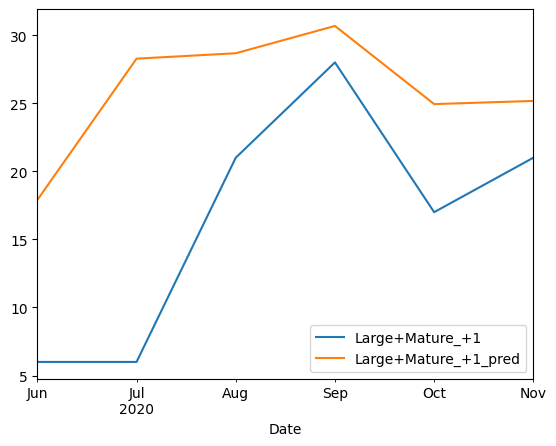

In [347]:
tbl_preds[(tbl_preds["Iter_n"] == 3) & (tbl_preds["FarmID"] == "GA331")][["Large+Mature_+1", "Large+Mature_+1_pred"]].plot()

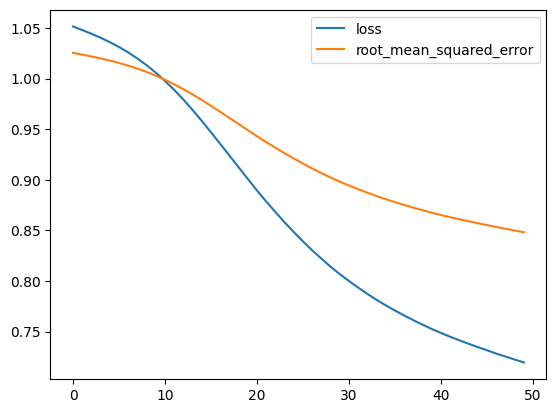

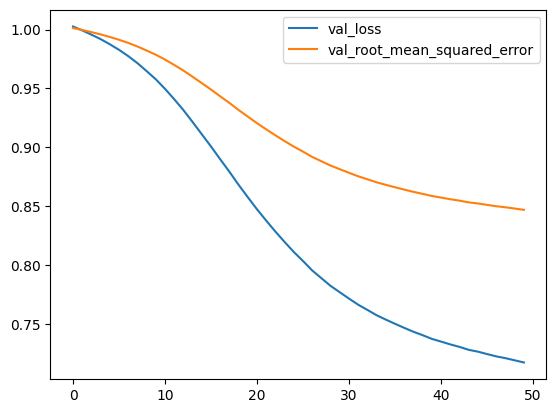

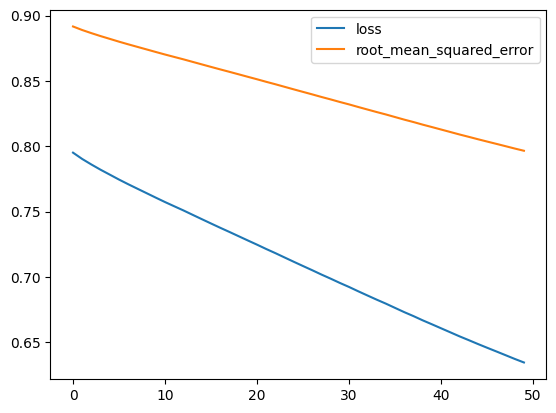

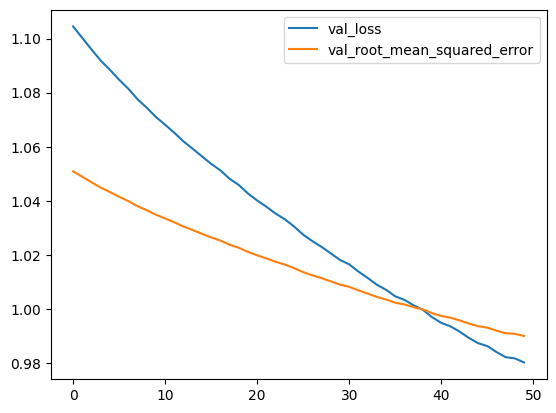

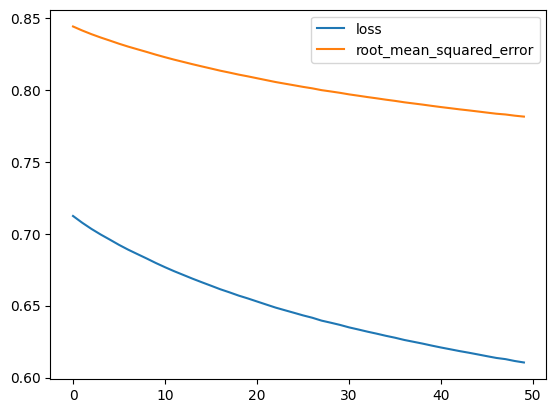

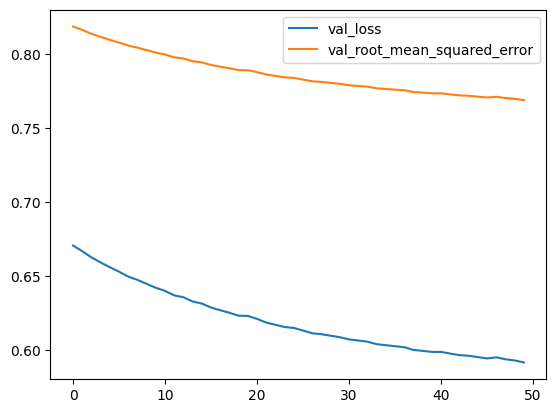

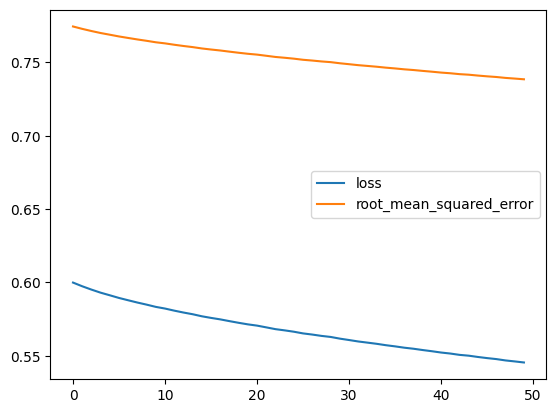

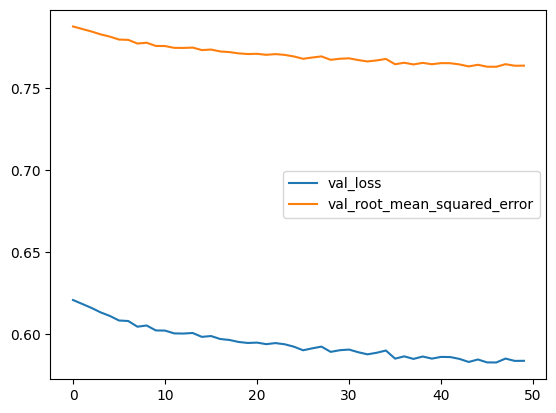

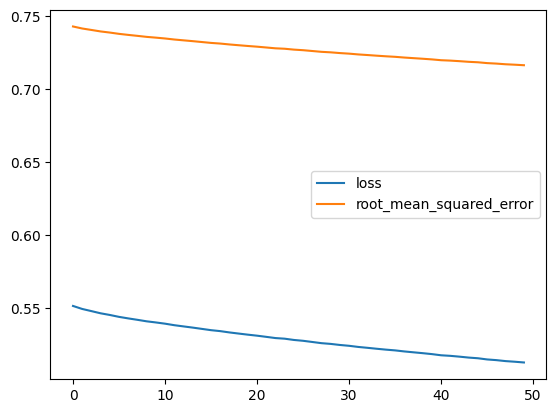

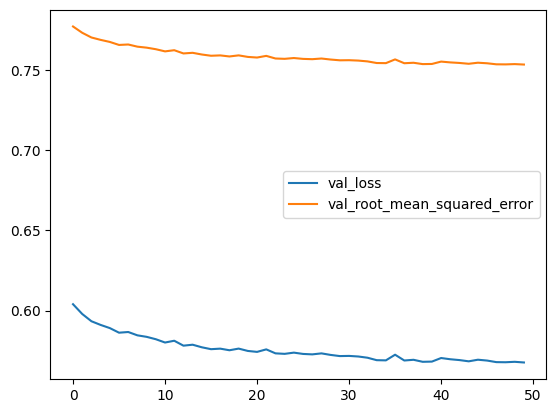

In [308]:
for i in range(1, 6):
    tbl_history[tbl_history["Iter_n"] == i][["loss", "root_mean_squared_error"]].plot()
    plt.show()
    tbl_history[tbl_history["Iter_n"] == i][["val_loss", "val_root_mean_squared_error"]].plot()
    plt.show()

<Axes: xlabel='year,month'>

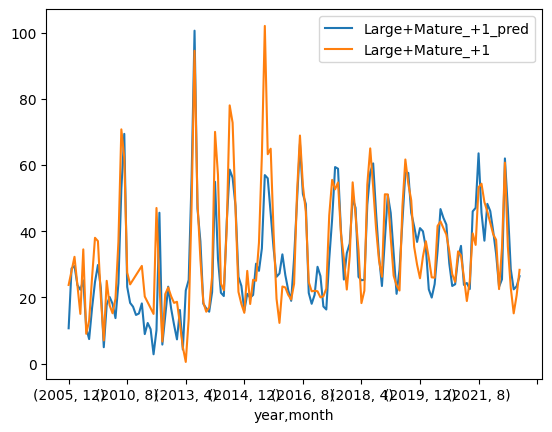

In [183]:
tbl_preds.groupby(["year", "month"]).mean()[["Large+Mature_+1_pred", "Large+Mature_+1"]].plot()

In [124]:
deepTimeSeriesForecaster.get_data()

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,Large+Mature_+2,Large+Mature_+3,Large+Mature_+4,Large+Mature_+5,Large+Mature_+6
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,AG10,1998,1,0.169366,-0.656804,2.204834,-0.526923,0.753522,-1.031030,-1.241228,...,-0.564720,-0.599677,2.546408,2.255104,-0.191988,0.272829,0.117890,-0.037049,-0.532853,0.164372
1998-02-01,AG10,1998,2,-0.180199,-0.191988,2.426871,1.922973,1.812810,1.292623,-0.672782,...,-0.599677,2.546408,2.255104,1.963800,0.272829,0.117890,-0.037049,-0.532853,0.164372,0.861596
1998-03-01,AG10,1998,3,-0.529764,0.272829,2.693168,3.259613,2.435196,2.562839,-0.753307,...,2.546408,2.255104,1.963800,-0.506460,0.117890,-0.037049,-0.532853,0.164372,0.861596,4.115311
1998-04-01,AG10,1998,4,-0.564720,0.117890,1.389877,2.668360,1.813778,2.530763,0.209351,...,2.255104,1.963800,-0.506460,-0.739503,-0.037049,-0.532853,0.164372,0.861596,4.115311,2.070119
1998-05-01,AG10,1998,5,-0.599677,-0.037049,0.970390,1.904345,1.271856,1.860911,-0.375811,...,1.963800,-0.506460,-0.739503,-0.599677,-0.532853,0.164372,0.861596,4.115311,2.070119,0.768633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,MA413,2022,9,-0.739503,0.334804,-1.110018,-1.087374,-1.282542,-1.188177,1.386224,...,-0.483155,-0.692894,-0.809416,-0.786112,0.086902,-0.532853,-0.749767,-0.718780,-0.718780,-0.718780
2022-10-01,MA413,2022,10,-0.786112,0.086902,-0.829240,-0.995107,-0.443307,-0.745154,0.476766,...,-0.692894,-0.809416,-0.786112,-0.786112,-0.532853,-0.749767,-0.718780,-0.718780,-0.718780,-0.966682
2022-11-01,MA413,2022,11,-0.716199,-0.532853,-0.423416,-1.218931,-0.262472,-1.035199,-0.757887,...,-0.809416,-0.786112,-0.786112,-0.762807,-0.749767,-0.718780,-0.718780,-0.718780,-0.966682,-0.935694


In [236]:
data_dict = deepTimeSeriesForecaster.split_category_data(5)

C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\3176103682.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\3176103682.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["valid"] = data_dict[f"iter_{i+1}"]["valid"].append(valid_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_16376\3176103682.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)


In [237]:
train, valid, test = data_dict["iter_1"]["train"], data_dict["iter_1"]["valid"], data_dict["iter_1"]["test"]

In [230]:
train.columns

Index(['FarmID', 'year', 'month', 'Tiny+Small', 'Large+Mature',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
       'precipitation_hours', 'windspeed_10m_max', 'windgusts_10m_max',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'Year sin',
       'Year cos', 'Tiny+Small_+1', 'Tiny+Small_+2', 'Tiny+Small_+3',
       'Tiny+Small_+4', 'Tiny+Small_+5', 'Tiny+Small_+6', 'Large+Mature_+1',
       'Large+Mature_+2', 'Large+Mature_+3', 'Large+Mature_+4',
       'Large+Mature_+5', 'Large+Mature_+6'],
      dtype='object')

In [238]:
train_dummies = pd.get_dummies(train, columns=["FarmID"])
valid_dummies = pd.get_dummies(valid, columns=["FarmID"])
test_dummies = pd.get_dummies(test, columns=["FarmID"])

In [239]:
X_train, y_train = deepTimeSeriesForecaster.df_to_X_y_lags(train_dummies.drop(columns = ["year", "month"]))

In [240]:
X_train.shape

(1566, 12, 91)

In [257]:
train["Tiny+Small_+1"].head(20)

0    -0.180199
1    -0.529764
2    -0.564720
3    -0.599677
4     2.546408
5     2.255104
6     1.963800
7    -0.506460
8    -0.739503
9    -0.599677
10   -0.459851
11   -0.646286
12   -0.681242
13   -0.716199
14   -0.413242
15   -0.110286
16    0.985018
17    0.798583
18    0.507279
19    0.215975
Name: Tiny+Small_+1, dtype: float64

In [249]:
train.columns

Index(['FarmID', 'year', 'month', 'Tiny+Small', 'Large+Mature',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
       'precipitation_hours', 'windspeed_10m_max', 'windgusts_10m_max',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'Year sin',
       'Year cos', 'Tiny+Small_+1', 'Tiny+Small_+2', 'Tiny+Small_+3',
       'Tiny+Small_+4', 'Tiny+Small_+5', 'Tiny+Small_+6', 'Large+Mature_+1',
       'Large+Mature_+2', 'Large+Mature_+3', 'Large+Mature_+4',
       'Large+Mature_+5', 'Large+Mature_+6'],
      dtype='object')

In [253]:
pd.DataFrame(X_train[0])[25]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
Name: 25, dtype: float64

In [247]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.681242,-0.716199,-0.413242,-0.110286,0.985018,0.798583,-0.718780,-0.532853,-0.625816,-0.718780,0.055914,1.078510
1,-0.716199,-0.413242,-0.110286,0.985018,0.798583,0.507279,-0.532853,-0.625816,-0.718780,0.055914,1.078510,1.620796
2,-0.413242,-0.110286,0.985018,0.798583,0.507279,0.215975,-0.625816,-0.718780,0.055914,1.078510,1.620796,2.163082
3,-0.110286,0.985018,0.798583,0.507279,0.215975,-0.599677,-0.718780,0.055914,1.078510,1.620796,2.163082,1.171474
4,0.985018,0.798583,0.507279,0.215975,-0.599677,-0.615213,0.055914,1.078510,1.620796,2.163082,1.171474,0.593036
...,...,...,...,...,...,...,...,...,...,...,...,...
1561,-0.110286,-0.017069,0.076149,-0.599677,0.309192,0.542236,0.179865,0.458755,0.489743,-0.037049,-0.408902,-0.594828
1562,-0.017069,0.076149,-0.599677,0.309192,0.542236,-0.040373,0.458755,0.489743,-0.037049,-0.408902,-0.594828,-0.068037
1563,0.076149,-0.599677,0.309192,0.542236,-0.040373,-0.506460,0.489743,-0.037049,-0.408902,-0.594828,-0.068037,0.489743
1564,-0.599677,0.309192,0.542236,-0.040373,-0.506460,-0.156895,-0.037049,-0.408902,-0.594828,-0.068037,0.489743,0.551719


In [241]:
y_train.shape

(1566, 12)